In [106]:
# import os
# os.environ["KERAS_BACKEND"] = "torch"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["TORCH_USE_CUDA_DSA"] = "1"
import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from scipy.stats import skew, kurtosis
# from scipy.fftpack import fft

from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch

In [107]:
df_sequential = pd.read_csv('subsequences_raw.csv')
df_sequential_new_user = pd.read_csv('subsequences_test_raw.csv')
df_sequential.head()



,new_user_id,total_acc,x_acc,y_acc,z_acc,num_of_samples,signal_length_in_sec
0,0,"[0.7362116837612153, 0.8161704566822283, 2.322...","[0.2941316, -0.49968776, -2.1783454, -2.797762...","[-0.6356053, -0.6044512, 0.7134906, 1.3548992,...","[-0.22693644, -0.22602014, 0.37201694, -0.2776...",40,2
1,0,"[1.3777305229373487, 1.5960753374387007, 1.203...","[1.1114693, 1.215011, 0.9126327, 0.21197024, 0...","[-0.6337727, -0.82894415, -0.40378192, -0.9318...","[-0.5109888, -0.6197228, -0.67347896, -0.37812...",40,2
2,0,"[2.425892007118064, 3.302566174850101, 1.90556...","[1.4813483, 2.0045543, 1.8689423, 1.7660115, 0...","[-1.9147571, -2.6212227, -0.3643811, -3.342960...","[-0.15577064, -0.1337795, -0.07391469, -0.0665...",40,2
3,0,"[0.9513855617281761, 1.9683277319562844, 1.314...","[0.66767573, -1.0225884, 0.19639318, -0.015882...","[-0.6423248, 1.6542231, 1.2999213, -1.4358387,...","[0.21624629, -0.3036, 0.019242255, -0.42760566...",40,2
4,0,"[2.329359891123871, 1.6620954042937637, 0.8495...","[-1.8026633, -0.8240572, 0.4560109, 1.2605205,...","[1.3573426, 1.325883, 0.46822822, -0.1301143, ...","[0.57787853, 0.5705481, 0.54275376, 0.66553766...",40,2


In [108]:
def prepare_data(df_sequential):
    """
    Prepares the sequential data for further processing.

    Args:
        df_sequential (pd.DataFrame): DataFrame containing the sequential data.

    Returns:
        tuple: Processed feature data (X_data) and labels (y_sequential)
    """
    # Drop unnecessary columns and separate features and labels
    X_sequential = df_sequential.drop(columns=['new_user_id', 'num_of_samples', 'signal_length_in_sec'])
    y_sequential = df_sequential['new_user_id']

    # # Extract the number of samples
    # num_of_samples = df_sequential['num_of_samples'].iloc[0]

    # Convert the lists in 'total_acc', 'x_acc', 'y_acc', 'z_acc' columns to numpy arrays
    def convert_to_array(series: pd.Series):
        return np.array(series.apply(eval).to_list())

    X_total_acc = convert_to_array(X_sequential['total_acc'])
    X_x_acc = convert_to_array(X_sequential['x_acc'])
    X_y_acc = convert_to_array(X_sequential['y_acc'])
    X_z_acc = convert_to_array(X_sequential['z_acc'])

    # Stack the accelerometer data along the last dimension
    X_data = np.stack((X_total_acc, X_x_acc, X_y_acc, X_z_acc), axis=-1)

    # Ensure the shape is correct (samples, timesteps, features)
    print(X_data.shape)  # Expected: (num_samples, num_of_samples, 4)

    return X_data, y_sequential


X_data, y_sequential = prepare_data(df_sequential)
X_data_new_user, y_sequential_new_user = prepare_data(df_sequential_new_user)

# Split the data
X_train_sequential, X_test_sequential, y_train_sequential, y_test_sequential = train_test_split(X_data, y_sequential, test_size=0.2, random_state=42)
X_train_new_user, X_test_new_user, y_train_new_user, y_test_new_user = train_test_split(X_data_new_user, y_sequential_new_user, test_size=0.2, random_state=42)

(30993, 40, 4)
(312, 40, 4)


In [110]:
num_classes = y_sequential.nunique()

print(num_classes)

190


In [113]:
# Define the model creation function
def create_lstm_model(input_shape, num_classes=10):
    """Creates a Keras LSTM model for accelerometer data classification.

    Args:
        input_shape (tuple): Shape of the input data (time_steps, features).
        num_classes (int): Number of classes for classification (default: 10).

    Returns:
        keras.Model: The compiled LSTM model.
    """
    model = keras.Sequential([
        keras.layers.InputLayer(shape=input_shape, name="input_acceleration"),

        # LSTM layers
        keras.layers.LSTM(64, return_sequences=True, name="lstm_1"), 
        keras.layers.LSTM(32, name="lstm_2"), 

        # Dense layers for classification
        keras.layers.Dense(64, activation="relu", name="dense_1"),
        keras.layers.Dropout(0.5, name='dropout'),  # Add dropout for regularization
        keras.layers.Dense(num_classes, activation="softmax", name="output_class_base"),
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",  # Assuming integer labels (new_user_id)
        metrics=["accuracy"]
        
    )
    return model

In [134]:
# no of different users
num_classes = max(y_sequential)+1

input_shape = (X_train_sequential.shape[1], X_train_sequential.shape[2])  # timesteps, features
model = create_lstm_model(input_shape, num_classes=num_classes)

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 40, 64)            │     17,664 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_27 (LSTM)                  │ (None, 32)                │     12,416 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_30 (Dense)                │ (None, 64)                │      2,112 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_15 (Dropout)            │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_31 (Dense)                │ (None, 192)               │     12,480 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 44,672 (174.50 KB)

 Trainable params: 44,672 (174.50 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
# callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)

In [116]:

# Train the model
history = model.fit(
    X_train_sequential,
    y_train_sequential,
    epochs=100,  # Adjust the number of epochs as needed
    batch_size=64,  # Adjust batch size as needed
    validation_data=(X_test_sequential, y_test_sequential),
    callbacks=[early_stopping, reduce_lr, tensorboard]
)

Epoch 1/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.0928 - loss: 4.3867 - val_accuracy: 0.3541 - val_loss: 2.5799 - learning_rate: 0.0010
Epoch 2/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.2789 - loss: 2.6868 - val_accuracy: 0.4823 - val_loss: 1.8432 - learning_rate: 0.0010
Epoch 3/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.4279 - loss: 2.0462 - val_accuracy: 0.5940 - val_loss: 1.4247 - learning_rate: 0.0010
Epoch 4/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.5298 - loss: 1.6929 - val_accuracy: 0.6798 - val_loss: 1.1570 - learning_rate: 0.0010
Epoch 5/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.6026 - loss: 1.4128 - val_accuracy: 0.7133 - val_loss: 0.9966 - learning_rate: 0.0010
Epoch 6/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.6701 - loss: 1.2114 - val_accuracy: 0.7843 - val_loss: 0.8247 - learning_rate: 0.0010
Epoch 7/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.7101 - l

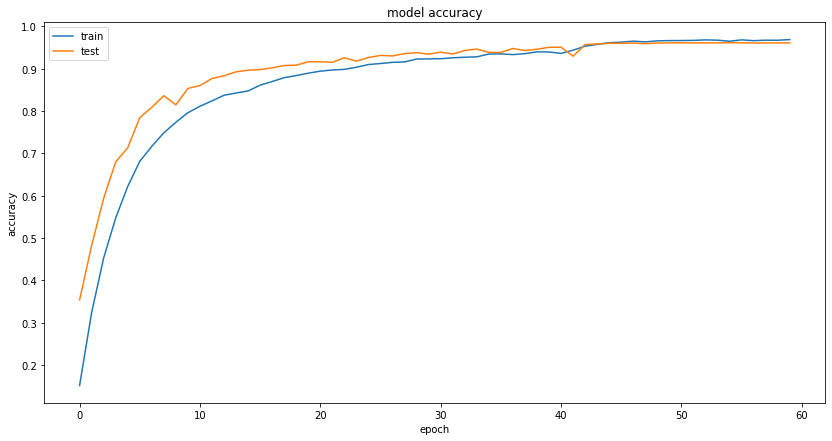

In [117]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [118]:
# save model weights to .h5 file
model.save_weights('gait_cycle_lstm_2sec_.weights.h5')


In [119]:
num_samples = X_train_sequential.shape[0]
num_timesteps = X_train_sequential.shape[1]
num_features = X_train_sequential.shape[2]

print(X_train_sequential.shape)

(24794, 40, 4)


In [148]:
base_model = create_lstm_model(input_shape=(num_timesteps, num_features), num_classes=num_classes)  # Your original num_classes
base_model.load_weights("gait_cycle_lstm_2sec_.weights.h5")

# Freeze the LSTM and Dense layers
for layer in base_model.layers: #[:-1]:  
    layer.trainable = False

# Create a new classification head
new_head = keras.Sequential([
    keras.layers.Dense(64, activation="relu", name="dense_new"),
    keras.layers.Dropout(0.5, name="dropout_new"),
    keras.layers.Dense(num_classes+1, activation="softmax", name="output_new")  # Increased number of classes
])

new_user_model = keras.Sequential([
    base_model,
    new_head
])

new_user_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [149]:
new_user_model.summary()


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ sequential_33 (Sequential)      │ ?                         │     44,672 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ sequential_34 (Sequential)      │ ?                         │          0 │
│                                 │                           │  (unbuilt) │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 44,672 (174.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 44,672 (174.50 KB)

In [150]:

# Train the model
history = new_user_model.fit(
    X_train_new_user,
    y_train_new_user,
    epochs=10,  # Adjust the number of epochs as needed
    batch_size=64,  # Adjust batch size as needed
    validation_data=(X_test_new_user, y_test_new_user)
)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.0000e+00 - loss: 5.2698 - val_accuracy: 0.0317 - val_loss: 5.2366
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0313 - loss: 5.2339 - val_accuracy: 0.1587 - val_loss: 5.1939
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1413 - loss: 5.1891 - val_accuracy: 0.3810 - val_loss: 5.1506
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3136 - loss: 5.1454 - val_accuracy: 0.9524 - val_loss: 5.1064
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6324 - loss: 5.1097 - val_accuracy: 1.0000 - val_loss: 5.0606
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8643 - loss: 5.0581 - val_accuracy: 1.0000 - val_loss: 5.0119
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9705 - loss: 5.0063 - val_accuracy: 1.0000 - val_loss: 4.9589
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9984 - loss: 4.9469 - val_accuracy: 1.0000 - val_loss: 4.9

Text(0.5, 0, 'epoch')

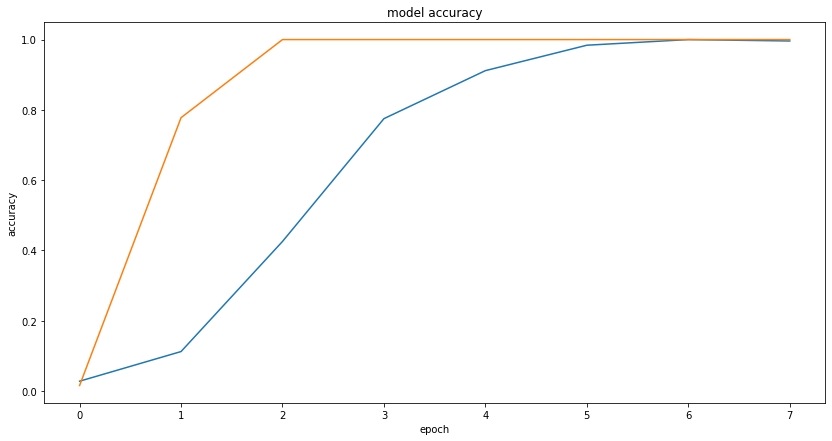

In [123]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')


In [133]:
from collections import Counter
def majority_voting(model_output):
    predicted_classes = np.argmax(model_output, axis=1)
    counter = Counter(predicted_classes)
    majority_class = counter.most_common(1)[0][0]
    return majority_class
    

output = model.predict(X_test_new_user)
# Get the majority class with tie-breaking
majority_class_with_tie_breaking = majority_voting(output)

print("Predicted Majority Class with Tie-Breaking:", majority_class_with_tie_breaking)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Predicted Majority Class with Tie-Breaking: 187


#### Now we need to hack around a bit
As TFLite currently does not support transfer learning afaik, we now add the new head to the model we want to export and freeze the weights of the base model here already.

In [ ]:
new_head = keras.Sequential([
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    # keras.layers.Dense(num_classes+1, activation="softmax")  # Increased number of classes
    keras.layers.Dense(1, activation='softmax')  # Placeholder output, we will reshape this on-device using the java api, like shown below
])


To reshape the output of the new head, we will use something like this on-device:
```java
import org.tensorflow.lite.Interpreter;

// ... Load TFLite model ...

try (Interpreter interpreter = new Interpreter(modelFile)) {
    // Get output tensor index and dimensions
    int outputIndex = interpreter.getOutputIndex(0);
    int[] outputDims = interpreter.getOutputTensor(outputIndex).shape();

    // Modify the number of classes (new_num_classes is your desired value)
    int newNumClasses = ...;  // Get new number of classes from your logic
    int[] newOutputShape = {outputDims[0], newNumClasses};  // Batch size, newNumClasses

    // Resize the output tensor
    interpreter.resizeInputTensor(outputIndex, newOutputShape);
    interpreter.allocateTensors();

    // ... (Start training) ...
}
```

In [212]:

for layer in base_model.layers: #[:-1]:  
    layer.trainable = False

new_user_model = keras.Sequential([
    base_model,
    new_head
])

class ModelToConvert(tf.Module):
    def __init__(self):
        self.model = keras.Sequential([
            base_model,
            new_head
        ])
        
        self.model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",  # Assuming integer labels (new_user_id)
            metrics=["accuracy"]
        )

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_timesteps, num_features], dtype=tf.float32),
        tf.TensorSpec(shape=[None], dtype=tf.int32)
    ])
    def train(self, X, y):
        with tf.GradientTape() as tape:
            predictions = self.model(X, training=True)
            loss = self.model.compute_loss(X, y, predictions)
        
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # # Update metrics
        # for metric in self.model.metrics:
        #    metric.update_state(y, predictions)

        self.model.compiled_metrics.update_state(y, predictions)
        result_metrics = {m.name: m.result() for m in self.model.metrics}
        result_metrics['loss'] = loss
        return result_metrics

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[None, num_timesteps, num_features], dtype=tf.float32)
    ])
    def infer(self, x):
        probas = self.model(x, training=False)
        return {'probabilities': probas}
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def save(self, checkpoint_path):
        checkpoint = tf.train.Checkpoint(model=self.model)
        saved_path = checkpoint.write(checkpoint_path)
        return {'checkpoint_path': saved_path}

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def restore(self, checkpoint_path):
        checkpoint = tf.train.Checkpoint(model=self.model)

        try:
            checkpoint.restore(checkpoint_path)
            return {'restored': True}
        except tf.errors.NotFoundError:
            # Handle the case where the checkpoint file is not found
            return {'restored': False, 'error': 'Checkpoint not found'}

In [214]:
model_to_convert = ModelToConvert()

# train the model
model_to_convert.train(X_train_new_user, y_train_new_user)

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4359574>,
 'compile_metrics': {'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>}}

In [220]:
predicted_class = majority_voting(model_to_convert.infer(X_test_new_user)['probabilities'])

In [222]:
predicted_class

186

In [215]:
model_to_convert.save('model_checkpoint')

{'checkpoint_path': <tf.Tensor: shape=(), dtype=string, numpy=b'model_checkpoint'>}

In [216]:
model_to_convert.restore('model_checkpoint')

TypeError: in user code:

    File "C:\Users\Lks\AppData\Local\Temp\ipykernel_17676\3914707437.py", line 61, in restore  *
        checkpoint.restore(checkpoint_path)

    TypeError: Expected binary or unicode string, got <tf.Tensor 'checkpoint_path:0' shape=() dtype=string>


## TODO NOTES
https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/on_device_training/overview.ipynb#scrollTo=d8577c80
https://blog.tensorflow.org/2021/11/on-device-training-in-tensorflow-lite.html
https://www.tensorflow.org/lite/android/quickstart
https://www.tensorflow.org/lite/guide/inference